In [1]:
import pandas as pd
import numpy as np
import os
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE
from tqdm import tqdm
from keras.utils import to_categorical

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import ADASYN
from keras.utils import to_categorical
import pandas as pd

def preprocess_gene_data(file_path):
    """
    Preprocess gene modality data for DNN
    
    Parameters:
    file_path (str): Path to the CSV file containing gene data
    
    Returns:
    tuple: Processed X_train, X_test, y_train, y_test for DNN
    """
    # Load the gene modality dataset
    df_genes = pd.read_csv(file_path)
    
    # Separate features and target
    X = df_genes.iloc[:, :-1]
    y = df_genes.iloc[:, -1]
    
    # Remove non-numeric columns
    numeric_cols = X.select_dtypes(include=['float64', 'int64']).columns
    X_numeric = X[numeric_cols]
    
    # Fill missing values 
    X_numeric = X_numeric.fillna(X_numeric.mean())
    
    # Standardize numeric features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_numeric)
    
    # Reduce dimensionality using PCA
    pca = PCA(n_components=0.95)
    X_pca = pca.fit_transform(X_scaled)
    print(f"Gene data PCA: {pca.n_components_} components selected, explained variance ratio: {sum(pca.explained_variance_ratio_):.2f}")
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)
    
    # Handle class imbalance using ADASYN
    adasyn = ADASYN(random_state=42)
    X_train_resampled, y_train_resampled = adasyn.fit_resample(X_train, y_train)
    
    # Label encoding and one-hot encoding for DNN
    le = LabelEncoder()
    y_train_int = le.fit_transform(y_train_resampled)
    y_test_int = le.transform(y_test)
    y_train_categorical = to_categorical(y_train_int)
    y_test_categorical = to_categorical(y_test_int)
    
    return (X_train_resampled, X_test, y_train_categorical, y_test_categorical, 
            y_train_int, y_test_int, le)

def preprocess_images(feature_folder, labels_file):
    """
    Preprocess pathological image data for CNN
    
    Parameters:
    feature_folder (str): Path to folder containing image features
    labels_file (str): Path to CSV file with slide labels
    
    Returns:
    tuple: Processed X_train, X_test, y_train, y_test for CNN
    """
    # Read labels
    df_labels = pd.read_csv(labels_file)
    aggregated_features, labels = [], []

    # Process image features
    for _, row in tqdm(df_labels.iterrows(), total=len(df_labels), desc="Processing images"):
        slide_id = row['slide_id']
        label = row['SUBTYPE']
        feature_file = os.path.join(feature_folder, f"{slide_id}.pt")

        if os.path.exists(feature_file):
            features = torch.load(feature_file)
            if len(features.shape) == 2:  # Ensure valid feature shape
                avg_gray_value = features.mean(axis=1)
                if avg_gray_value.mean() < 240:  # Filter out "white noise"
                    aggregated_features.append(features.mean(axis=0).numpy())
                    labels.append(label)
    
    X_images = np.array(aggregated_features)
    y_images = np.array(labels)
    
    # Dimensionality reduction using PCA
    pca = PCA(n_components=0.95)
    X_images_pca = pca.fit_transform(X_images)
    print(f"Image data PCA: {pca.n_components_} components selected, explained variance ratio: {sum(pca.explained_variance_ratio_):.2f}")
    
    # Label encoding
    le = LabelEncoder()
    y_images_int = le.fit_transform(y_images)
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X_images_pca, y_images_int, test_size=0.2, random_state=42
    )
    
    return X_train, X_test, y_train, y_test, le

# Preprocess gene and image data (run this cell first)
(X_train_genes, X_test_genes, y_train_genes_cat, y_test_genes_cat, 
 y_train_genes_int, y_test_genes_int, gene_label_encoder) = preprocess_gene_data('BRCA.csv')
X_train_images, X_test_images, y_train_images, y_test_images, image_label_encoder = preprocess_images(
    "../features", "labels.csv"
)
# import joblib

# # Save gene data
# joblib.dump((X_train_genes, X_test_genes, y_train_genes_cat, y_test_genes_cat, 
#              y_train_genes_int, y_test_genes_int, gene_label_encoder), 'processed_gene_data.pkl')

# # Save image data
# joblib.dump((X_train_images, X_test_images, y_train_images, y_test_images, image_label_encoder), 'processed_image_data.pkl')


Gene data PCA: 681 components selected, explained variance ratio: 0.95


Processing images:   0%|                                                                       | 0/893 [00:00<?, ?it/s]C:\Users\vinay\AppData\Local\Temp\ipykernel_13516\2164357368.py:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on Gi

Image data PCA: 80 components selected, explained variance ratio: 0.95


In [5]:
import joblib
# Load gene data
X_train_genes, X_test_genes, y_train_genes_cat, y_test_genes_cat, \
y_train_genes_int, y_test_genes_int, gene_label_encoder = joblib.load('0.95processed_gene_data.pkl')

# Load image data
X_train_images, X_test_images, y_train_images, y_test_images, image_label_encoder = joblib.load('0.95processed_image_data.pkl')

Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV 1/5] END C=0.01, gamma=0.0001, kernel=sigmoid;, score=0.839 total time=  10.5s
[CV 2/5] END C=0.01, gamma=0.0001, kernel=sigmoid;, score=0.831 total time=  11.2s
[CV 3/5] END C=0.01, gamma=0.0001, kernel=sigmoid;, score=0.845 total time=   9.3s
[CV 4/5] END C=0.01, gamma=0.0001, kernel=sigmoid;, score=0.870 total time=   9.0s
[CV 5/5] END C=0.01, gamma=0.0001, kernel=sigmoid;, score=0.831 total time=   7.7s
[CV 1/5] END C=0.01, gamma=1e-05, kernel=sigmoid;, score=0.262 total time=  13.1s
[CV 2/5] END C=0.01, gamma=1e-05, kernel=sigmoid;, score=0.262 total time=  13.4s
[CV 3/5] END C=0.01, gamma=1e-05, kernel=sigmoid;, score=0.265 total time=  10.9s
[CV 4/5] END C=0.01, gamma=1e-05, kernel=sigmoid;, score=0.263 total time=  10.3s
[CV 5/5] END C=0.01, gamma=1e-05, kernel=sigmoid;, score=0.263 total time=  12.8s
[CV 1/5] END C=0.01, gamma=1e-06, kernel=sigmoid;, score=0.262 total time=  13.3s
[CV 2/5] END C=0.01, gamma=1e-06

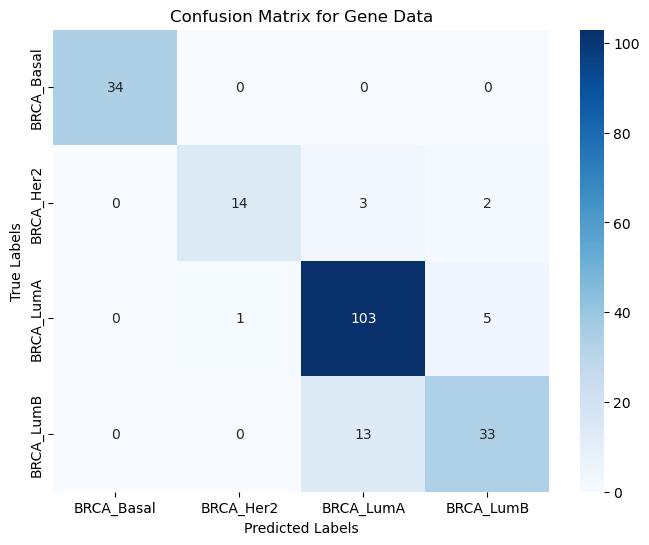

Gene Data MCC: 0.8179
Gene Data AUC: 0.9693
Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV 1/5] END C=0.001, gamma=0.001, kernel=sigmoid;, score=0.469 total time=   0.3s
[CV 2/5] END C=0.001, gamma=0.001, kernel=sigmoid;, score=0.469 total time=   0.3s
[CV 3/5] END C=0.001, gamma=0.001, kernel=sigmoid;, score=0.469 total time=   0.3s
[CV 4/5] END C=0.001, gamma=0.001, kernel=sigmoid;, score=0.469 total time=   0.1s
[CV 5/5] END C=0.001, gamma=0.001, kernel=sigmoid;, score=0.472 total time=   0.1s
[CV 1/5] END C=0.001, gamma=0.0001, kernel=sigmoid;, score=0.469 total time=   0.1s
[CV 2/5] END C=0.001, gamma=0.0001, kernel=sigmoid;, score=0.469 total time=   0.1s
[CV 3/5] END C=0.001, gamma=0.0001, kernel=sigmoid;, score=0.469 total time=   0.1s
[CV 4/5] END C=0.001, gamma=0.0001, kernel=sigmoid;, score=0.469 total time=   0.1s
[CV 5/5] END C=0.001, gamma=0.0001, kernel=sigmoid;, score=0.472 total time=   0.1s
[CV 1/5] END C=0.001, gamma=1e-05, kernel=sigmoid;, score=0.

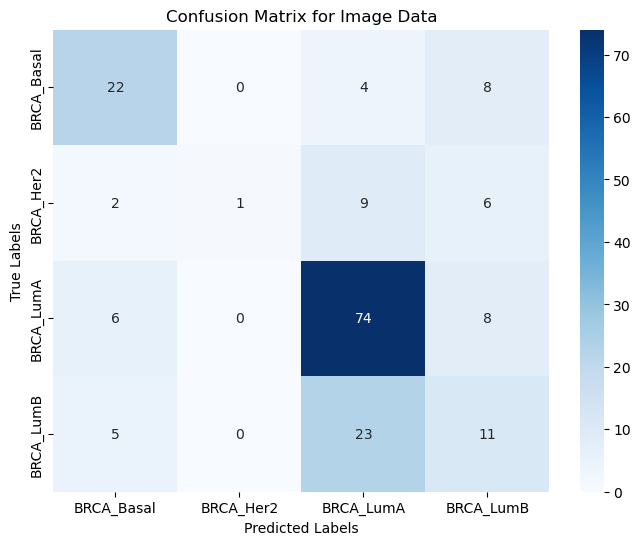

Image Data MCC: 0.3694
Image Data AUC: 0.7753
Fusion Model Accuracy: 0.8771

Classification Report for Fusion Model:
              precision    recall  f1-score   support

  BRCA_Basal       1.00      1.00      1.00        28
   BRCA_Her2       0.93      0.72      0.81        18
   BRCA_LumA       0.85      0.96      0.90        94
   BRCA_LumB       0.84      0.67      0.74        39

    accuracy                           0.88       179
   macro avg       0.90      0.84      0.86       179
weighted avg       0.88      0.88      0.87       179



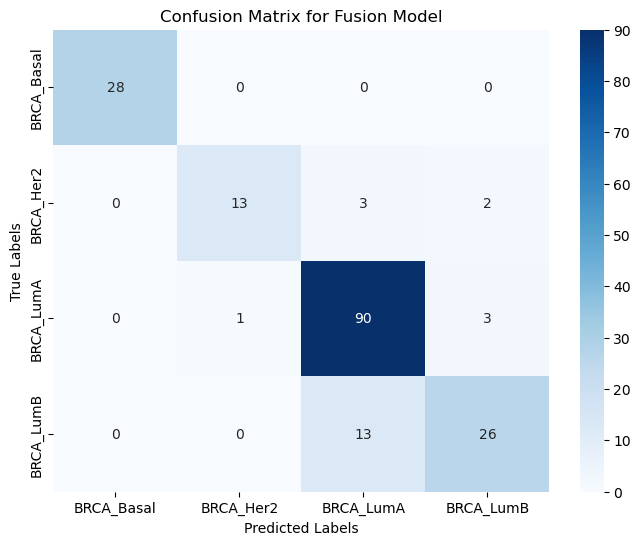

Fusion Model MCC: 0.8067
Fusion Model AUC: 0.9656


In [3]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, matthews_corrcoef, roc_auc_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# SVM with RBF kernel and Grid Search for gene data
param_grid_gene = {
    'C': [0.01, 0.1, 1, 10, 100],
    'gamma': [0.0001, 0.00001, 0.000001],
    'kernel': ['sigmoid'],
}

svm_gene = SVC(probability=True)
grid_search_gene = GridSearchCV(svm_gene, param_grid_gene, cv=5,verbose=3)
grid_search_gene.fit(X_train_genes, y_train_genes_int)

# Evaluate SVM on gene data
pred_dnn_probs = grid_search_gene.best_estimator_.predict_proba(X_test_genes)
pred_dnn = np.argmax(pred_dnn_probs, axis=1)
accuracy_dnn = accuracy_score(y_test_genes_int, pred_dnn)
print(f"SVM Gene Accuracy: {accuracy_dnn:.4f}")

# Classification Report for Gene Data
print("\nClassification Report for Gene Data:")
print(classification_report(y_test_genes_int, pred_dnn, target_names=gene_label_encoder.classes_))

# Confusion Matrix for Gene Data
conf_matrix_gene = confusion_matrix(y_test_genes_int, pred_dnn)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_gene, annot=True, fmt='d', cmap='Blues', 
            xticklabels=gene_label_encoder.classes_, 
            yticklabels=gene_label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Gene Data')
plt.show()

# Matthews Correlation Coefficient (MCC) for Gene Data
mcc_gene = matthews_corrcoef(y_test_genes_int, pred_dnn)
print(f"Gene Data MCC: {mcc_gene:.4f}")

# AUC for Gene Data
try:
    auc_gene = roc_auc_score(y_test_genes_int, pred_dnn_probs, multi_class='ovr', average='weighted')
    print(f"Gene Data AUC: {auc_gene:.4f}")
except ValueError as e:
    print(f"AUC calculation error for Gene Data: {e}")

# SVM with RBF kernel and Grid Search for image data
param_grid_image = {
    'C': [0.001, 0.01, 0.1, 1, 10, 50],
    'gamma': [0.001, 0.0001, 0.00001],
    'kernel': ['sigmoid'],
}

svm_image = SVC(probability=True)
grid_search_image = GridSearchCV(svm_image, param_grid_image, cv=5,verbose=3)
grid_search_image.fit(X_train_images, y_train_images)

# Evaluate SVM on image data
pred_cnn_probs = grid_search_image.best_estimator_.predict_proba(X_test_images)
pred_cnn = np.argmax(pred_cnn_probs, axis=1)
accuracy_cnn = accuracy_score(y_test_images, pred_cnn)
print(f"SVM Image Accuracy: {accuracy_cnn:.4f}")

# Classification Report for Image Data
print("\nClassification Report for Image Data:")
print(classification_report(y_test_images, pred_cnn, target_names=gene_label_encoder.classes_))

# Confusion Matrix for Image Data
conf_matrix_image = confusion_matrix(y_test_images, pred_cnn)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_image, annot=True, fmt='d', cmap='Blues', 
            xticklabels=gene_label_encoder.classes_, 
            yticklabels=gene_label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Image Data')
plt.show()

# Matthews Correlation Coefficient (MCC) for Image Data
mcc_image = matthews_corrcoef(y_test_images, pred_cnn)
print(f"Image Data MCC: {mcc_image:.4f}")

# AUC for Image Data
try:
    auc_image = roc_auc_score(y_test_images, pred_cnn_probs, multi_class='ovr', average='weighted')
    print(f"Image Data AUC: {auc_image:.4f}")
except ValueError as e:
    print(f"AUC calculation error for Image Data: {e}")

# Align prediction arrays for fusion
min_samples = min(pred_dnn_probs.shape[0], pred_cnn_probs.shape[0])
pred_dnn_aligned = pred_dnn_probs[:min_samples]
pred_cnn_aligned = pred_cnn_probs[:min_samples]
y_test_aligned = y_test_genes_int[:min_samples]

# Fusion of SVM outputs
alpha, beta = 0.88185, 0.11815
fused_predictions = alpha * pred_dnn_aligned + beta * pred_cnn_aligned
final_predictions = np.argmax(fused_predictions, axis=1)

# Evaluate fusion model
accuracy_fusion = accuracy_score(y_test_aligned, final_predictions)
print(f"Fusion Model Accuracy: {accuracy_fusion:.4f}")

# Classification Report for Fusion Model
print("\nClassification Report for Fusion Model:")
print(classification_report(y_test_aligned, final_predictions, 
                            target_names=gene_label_encoder.classes_))

# Confusion Matrix for Fusion Model
conf_matrix_fusion = confusion_matrix(y_test_aligned, final_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_fusion, annot=True, fmt='d', cmap='Blues', 
            xticklabels=gene_label_encoder.classes_, 
            yticklabels=gene_label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Fusion Model')
plt.show()

# Matthews Correlation Coefficient (MCC) for Fusion Model
mcc_fusion = matthews_corrcoef(y_test_aligned, final_predictions)
print(f"Fusion Model MCC: {mcc_fusion:.4f}")

# AUC for Fusion Model
try:
    auc_fusion = roc_auc_score(y_test_aligned, fused_predictions, multi_class='ovr', average='weighted')
    print(f"Fusion Model AUC: {auc_fusion:.4f}")
except ValueError as e:
    print(f"AUC calculation error for Fusion Model: {e}")
